In [1]:
import functools
import itertools
import modelgym
import numpy as np
import os
import pickle

from collections import OrderedDict
from hyperopt.mongoexp import MongoTrials
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from modelgym.metric import RocAuc, Accuracy
from modelgym.tracker import ProgressTrackerFile, ProgressTrackerMongo
from modelgym.trainer import Trainer
from modelgym.util import TASK_CLASSIFICATION, split_and_preprocess

/Users/f-minkin/.pyenv/versions/3.6.2/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
########### NROWS, N_ESTIMATORS, N_PROBES, TEST_SIZE, N_CV_SPLITS, OPTIMIZER
config_tuple = {
    'test': (1000, 100,  2, 0.5, 2, 'random'),
    'pror': (None, 1000, 100, 0.5, 2, 'random'), # production with random hyperopt suggestor
    'prot': (None, 1000, 100, 0.5, 2, 'tpe'),    # production with tpe hyperopt suggestor
    'demi': (10000, 100, 5, 0.5, 2, 'random')
}
CONFIG = 'test' if 'EXP_CONFIG' not in os.environ else os.environ['EXP_CONFIG']
NROWS, N_ESTIMATORS, N_PROBES, TEST_SIZE, N_CV_SPLITS, OPTIMIZER = config_tuple[CONFIG]
CANDIDATES = OrderedDict([
    ('XGBoost', modelgym.XGBModel), 
    ('LightGBM', modelgym.LGBModel),
    ('RandomForestClassifier', modelgym.RFModel)
])
RESULTS_DIR = "results"
LOAD_CACHE = False
if 'MONGO_PORT_27017_TCP_ADDR' in os.environ:
    mongo_host = os.environ['MONGO_PORT_27017_TCP_ADDR'] if 'MONGO_PORT_27017_TCP_ADDR' in os.environ else 'cern-mc01h'
    mongo_port = int(os.environ['MONGO_PORT_27017_TCP_PORT']) if 'MONGO_PORT_27017_TCP_PORT' in os.environ else 27017
    mongo_db = os.environ['MONGO_DB'] if 'MONGO_DB' in os.environ else 'trials'
    tracker_factory = functools.partial(ProgressTrackerMongo, mongo_host, mongo_port, mongo_db, config_key=CONFIG)
    print ("Using Mongo as backend for tracking")
else:
    tracker_factory = functools.partial(ProgressTrackerFile, RESULTS_DIR, config_key=CONFIG)
    print ("Using File as backend for tracking")

print ("Running experiment cofiguration:", CONFIG)

Using File as backend for tracking
Running experiment cofiguration: test


## Download & read data file

In [3]:
%%bash 
if [ ! -d data ] ; then 
    mkdir data 
    cd data
    curl https://cernbox.cern.ch/index.php/s/N1dpSAPgl30szYM/download | gunzip -c > XY2d.pickle
    cd ..
fi
ls -l data

total 266224
-rw-r--r--  1 f-minkin  LD\Domain Users  136304022 Nov 13 02:57 XY2d.pickle


In [4]:
def read_data(fname, nrows=None, shuffle=True):
    with open(fname,'rb') as fh:
        X, y = pickle.load(fh,encoding='bytes')
    index = np.arange(X.shape[0])
    if nrows is None:
        nrows = X.shape[0]
    weights = np.ones(nrows) # uh, well...
    if shuffle:
        index_perm = np.random.permutation(index)
    else:
        index_perm = index
    return X[index_perm[:nrows]], y[index_perm[:nrows]], weights


X, y, weights = read_data("data/XY2d.pickle", nrows=NROWS)

In [5]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=TEST_SIZE)

In [6]:
cv_pairs, (dtrain, dtest) = split_and_preprocess(X_train.copy(), y_train, 
                                                X_test.copy(), y_test, 
                                                cat_cols=[], n_splits=N_CV_SPLITS)

## Run them all

In [7]:
def init_keys_dict():
    return dict(
        [(k, {'default_cv': None, 'tuned_cv': None, 'default_test': None, 'tuned_test': None, 'trials': None}) for k in
         CANDIDATES.keys()])


trackers = {}
custom_metrics = [RocAuc(), Accuracy()]
all_metrics = init_keys_dict()
trainer = Trainer(opt_evals=N_PROBES, n_estimators=N_ESTIMATORS)

In [8]:
def gym_training(trainer, model, all_metrics, trackers, cv_pairs, dtrain, dtest, mode):
    name = model.get_name()
    metrics = all_metrics[name]
    tracker = trackers[name]
    cv_key = mode + "_cv"
    test_key = mode + "_test"
    if metrics[cv_key] is None:
        if mode == "default":
            metrics[cv_key] = trainer.crossval_fit_eval(model, cv_pairs,
                                                        custom_metrics=custom_metrics)
        elif mode == "tuned":
            print('Hyperopt iterations:\n\n')
            metrics[cv_key] = trainer.crossval_optimize_params(model, cv_pairs, algo_name=OPTIMIZER,
                                                               trials=metrics['trials'],
                                                               tracker=tracker, 
                                                               custom_metrics=custom_metrics)
        else:
            raise ValueError("{0} not expected".format(mode))
        tracker._update_state(metrics[cv_key])
    trainer.print_result(metrics[cv_key], '{0} {1} result on CV'.format(mode, name),
                         extra_keys=[metric.name for metric in custom_metrics])

    if metrics[test_key] is None:
        metrics[test_key] = trainer.fit_eval(model, dtrain, dtest,
                                             metrics[cv_key]['params'],
                                             metrics[cv_key]['best_n_estimators'],
                                             custom_metrics=custom_metrics,
                                             compute_additional_statistics=True)
        tracker._update_state(metrics)
    trainer.print_result(metrics[test_key], '{0} {1} result on TEST'.format(mode, name),
                         extra_keys=[metric.name for metric in custom_metrics])

In [9]:
for model_class in CANDIDATES.values():
    model = model_class(TASK_CLASSIFICATION)
    name = model.get_name()
    print("\n" + "~" * 20, name, "~" * 20)
    trackers[name] = tracker_factory(model_name=name)
    if LOAD_CACHE:
        all_metrics[name] = trackers[name].load_state()

    gym_training(trainer, model, all_metrics, trackers, cv_pairs, dtrain, dtest, 'default')
    gym_training(trainer, model, all_metrics, trackers, cv_pairs, dtrain, dtest, 'tuned')

    trackers[name].save_state()


~~~~~~~~~~~~~~~~~~~~ XGBoost ~~~~~~~~~~~~~~~~~~~~

default XGBoost result on CV:

loss = 0.37413947
best_n_estimators = 1
roc_auc = 0.766874
accuracy = 0.880000
params = {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'silent': 1}

default XGBoost result on TEST:

loss = 0.642897
n_estimators = 1
roc_auc = 0.633497
accuracy = 0.832000
params = {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'subsample': 1, 'objective': 'binary:logistic', 'eval_metric': 'l

## Compare

In [10]:
full_results = {}
for i in CANDIDATES.keys():
    if i in trackers:
        tracker = trackers[i]
    else:
        tracker = tracker_factory(model_name=i)
        tracker.load_state()
    full_results.update({i:{'tuned': tracker.state['tuned_test'], 'default': tracker.state['default_test']}})

In [11]:

from modelgym.report import Report

rep = Report(results=full_results, models_dict=CANDIDATES,
             models_holder=trackers,
             test_set=dtest, metrics=custom_metrics,
             task_type=TASK_CLASSIFICATION)

### Plots


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



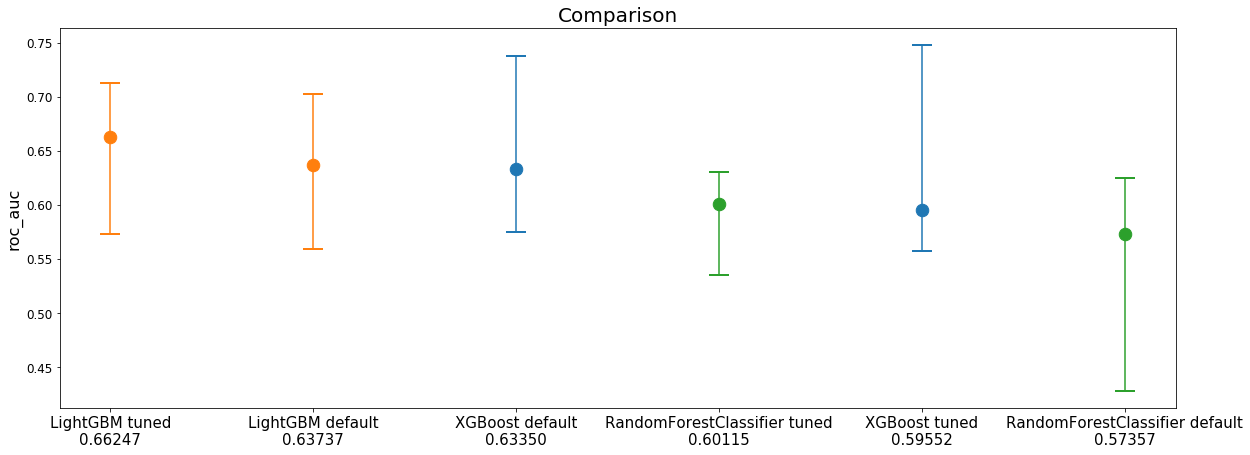


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



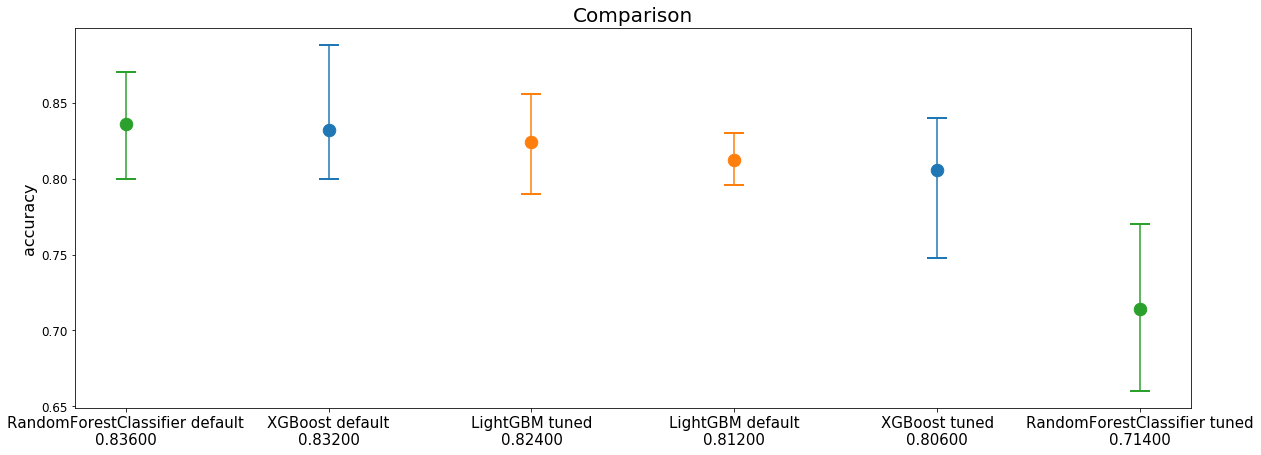

In [12]:
rep.plot_all_metrics()

### Check quality differences

In [13]:
rep.print_all_metric_results()


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                                   default               tuned
XGBoost                 0.633497 (+10.45%)   0.595521 (+3.83%)
LightGBM                0.637366 (+11.12%)  0.662470 (+15.50%)
RandomForestClassifier   0.573571 (+0.00%)   0.601146 (+4.81%)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

                                   default               tuned
XGBoost                 0.832000 (+16.53%)  0.806000 (+12.89%)
LightGBM                0.812000 (+13.73%)  0.824000 (+15.41%)
RandomForestClassifier  0.836000 (+17.09%)   0.714000 (-0.00%)


### Check correlation maps


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    roc_auc    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



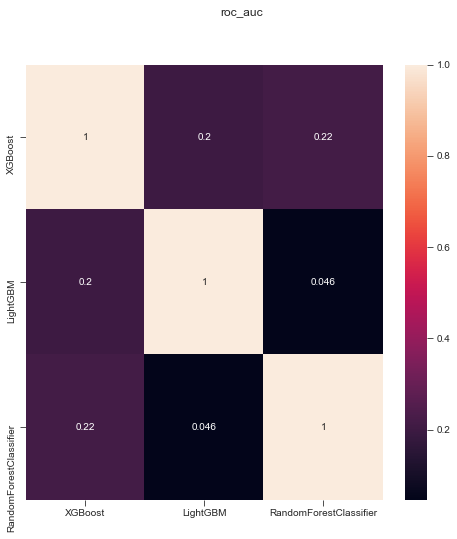


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    accuracy    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



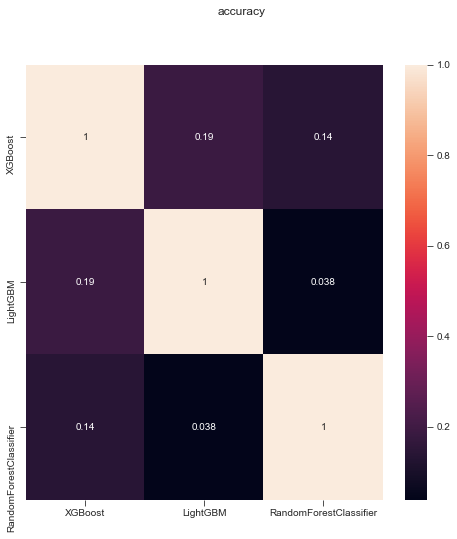

In [14]:
rep.plot_heatmaps()

In [18]:
# You can glance at everything at once using the following:
# rep.summary()

# Compare models with stat test

## Compare that out tuned RF model is statistically better than default

In [15]:
from sklearn.ensemble import RandomForestClassifier
default_rf_model = RandomForestClassifier()
default_rf_model.fit(dtrain.X, dtrain.y)

tuned_rf_model = full_results['RandomForestClassifier']['tuned']['bst']

print('Two models are different: {}, p-value {}'.format(
    *modelgym.util.compare_models_different(tuned_rf_model, default_rf_model, dtest)
))

Two models are different: False, p-value [[ 0.99343407]]


## Compare default LightGBM and default RF

In [16]:
import lightgbm
default_lightGBM_model = lightgbm.LGBMClassifier()
default_lightGBM_model.fit(dtrain.X, dtrain.y)

print('Two models are different: {}, p-value {}'.format(
    *modelgym.util.compare_models_different(default_lightGBM_model, default_rf_model, dtest)
))

Two models are different: True, p-value [[  5.99814530e-06]]
